# testing `p=4` for phylum and genus
note that both the "p__" phylum and "g__" genus have been removed

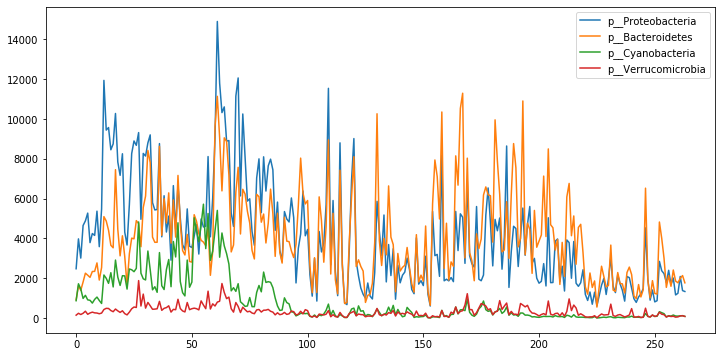

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas

p = 4

DAT = pandas.read_csv('../../bayesian_cbiomes/case_studies/MV_AR1/data/bacterial_OTU.csv')

# Aggregate the data by phyla, which is indicated in the third column ("phylum") of the dataset:
phyla = np.unique(DAT['phylum']) # extract unique phyla IDs

# remove catch-all "p__" phylum
phyla = phyla[phyla!='p__']

# sum all OTUs of that phylum
# use sums as rows for new DataFrame
PHY = pandas.DataFrame([DAT.loc[DAT['phylum']==phylum].iloc[:,8:].sum() for phylum in phyla])
# associate each row with phylum
PHY = PHY.set_index(phyla)
PHY.sum(axis=1)

index_maxp = np.argsort(PHY.sum(axis=1).values)[-p:][::-1]

PHY = PHY.iloc[index_maxp]

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(PHY.values.T)
ax.legend(PHY.index)
None

In [2]:
mod_code = '''data {
    int T;         //length of time series
    int p;         //number of variables
    matrix[p,T] Y; //matrix of observations; variables are rows; time is columns
    real phi_mu;   //PHI prior distribution parameter
    real phi_sigma; //PHI prior distribution parameter
}
parameters{
    matrix[p,p] PHI;     //dynamics matrix
    vector<lower=1E-15>[p] sigma;     //variances of stochastic forcing
    vector[p] init;      //mean of initial conditions as parameter vector
}
model{
    for (icol in 1:p){
        PHI[,icol] ~ normal(phi_mu,phi_sigma);
    }
    Y[,1] ~ normal(init, sigma);            //distribution of the initial conditions
    for(i in 2:T){
        Y[,i] ~ normal(PHI*Y[,i-1],sigma);  //conditional predictive distribution
    }
}
'''
mod = pystan.StanModel(model_code=mod_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd1ea11859c7683002ab7f53f1a0b8e4 NOW.


In [3]:
phi_mu = 0.0
phi_sigma = 1.0

dat_PHY = {'T':PHY.shape[1], 'p':PHY.shape[0], 'Y':PHY.values, 'phi_mu':phi_mu, 'phi_sigma':phi_sigma}
mcmc = mod.sampling(data=dat_PHY, iter=2000, warmup=1000)
print(mcmc)

Inference for Stan model: anon_model_dd1ea11859c7683002ab7f53f1a0b8e4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
PHI[1,1]   0.75  1.3e-3   0.08   0.59   0.69   0.75   0.81   0.92   3866    1.0
PHI[2,1]   0.08  1.5e-3   0.09  -0.09   0.02   0.08   0.14   0.26   3596    1.0
PHI[3,1]   0.04  3.5e-4   0.02-4.7e-3   0.03   0.04   0.06   0.09   4364    1.0
PHI[4,1] 7.6e-3  1.3e-4 8.7e-3-9.5e-3 1.8e-3 7.7e-3   0.01   0.02   4721    1.0
PHI[1,2]   0.09  1.2e-3   0.08  -0.06   0.04   0.09   0.14   0.24   4060    1.0
PHI[2,2]   0.73  1.3e-3   0.08   0.58   0.68   0.73   0.79   0.89   3919    1.0
PHI[3,2]-5.4e-3  3.3e-4   0.02  -0.05  -0.02-5.5e-3 9.3e-3   0.04   4289    1.0
PHI[4,2]   0.02  1.2e-4 8.0e-3 6.9e-3   0.02   0.02   0.03   0.04   4274    1.0
PHI[1,3]   0.42  2.3e-3   0.16    0.1   0.32   0.42   0.52   0.73   4571    1.0
PHI[2,3]   

In [4]:
niter = 2000
bin_edges = np.linspace(-1.2, 1.2, 101)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
hist_prior = np.zeros((bin_edges.size-1,bin_edges.size-1))
hist_posterior = np.zeros((bin_edges.size-1,bin_edges.size-1))

sqrt_p = np.sqrt(p)
for i in range(niter):
    eig = np.linalg.eigvals(np.random.normal(size=(p,p), loc=phi_mu, scale=phi_sigma))
    hist_prior += np.histogram2d(x=eig.real/sqrt_p, y=eig.imag/sqrt_p, bins=(bin_edges,bin_edges))[0]

for i in range(mcmc['PHI'].shape[0]):
    eig = np.linalg.eigvals(mcmc['PHI'][i,:,:])
    hist_posterior += np.histogram2d(x=eig.real/sqrt_p, y=eig.imag/sqrt_p, bins=(bin_edges,bin_edges))[0]


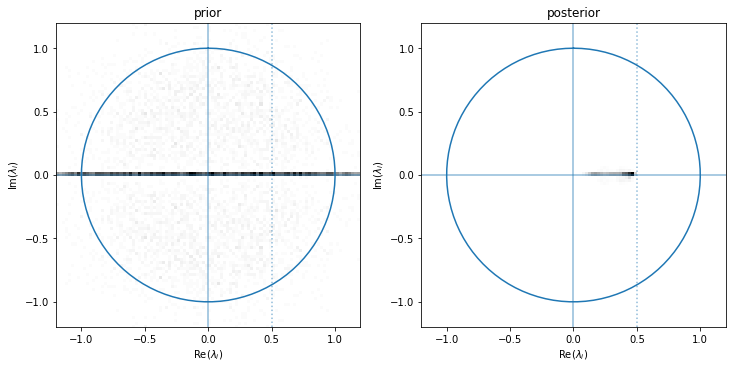

In [6]:
a = np.linspace(0.0, 2*np.pi, 100)
x_circ = np.sin(a)
y_circ = np.cos(a)

fig, axs = plt.subplots(ncols=2, subplot_kw={'aspect':1.0}, figsize=(12,6))
axs[0].pcolormesh(bin_edges, bin_edges, hist_prior.T, cmap=plt.get_cmap('gray_r'))
axs[1].pcolormesh(bin_edges, bin_edges, hist_posterior.T, cmap=plt.get_cmap('gray_r'))
for ax in axs.flat:
    ax.plot(x_circ, y_circ)
    ax.axvline(0.0, color='C0', alpha=0.5)
    ax.axvline(1.0/np.sqrt(p), color='C0', alpha=0.5, ls=':')
    ax.axhline(0.0, color='C0', alpha=0.5)
    ax.set(xlabel='Re($\lambda_i$)', ylabel='Im($\lambda_i$)')
ax
axs[0].set_title('prior')
axs[1].set_title('posterior')
None

### try again with genus

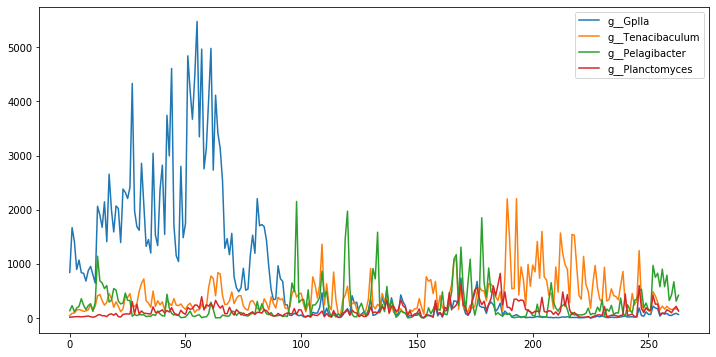

In [7]:
# Aggregate the data by genus, which is indicated in the column "genus" of the dataset:
genera = np.unique(DAT['genus']) # extract unique genera IDs

# remove catch-all "g__" genus
genera = genera[genera!='g__']

# sum all OTUs of that phylum
# use sums as rows for new DataFrame
gen = pandas.DataFrame([DAT.loc[DAT['genus']==genus].iloc[:,8:].sum() for genus in genera])
# associate each row with phylum
gen = gen.set_index(genera)
gen.sum(axis=1)

index_maxp = np.argsort(gen.sum(axis=1).values)[-p:][::-1]

gen = gen.iloc[index_maxp]

fig,ax = plt.subplots(figsize=(12,6))
ax.plot(gen.values.T)
ax.legend(gen.index)
None

In [8]:
phi_mu = 0.0
phi_sigma = 1.0

dat_gen = {'T':gen.shape[1], 'p':gen.shape[0], 'Y':gen.values, 'phi_mu':phi_mu, 'phi_sigma':phi_sigma}
mcmc_gen = mod.sampling(data=dat_gen, iter=2000, warmup=1000)
print(mcmc_gen)

Inference for Stan model: anon_model_dd1ea11859c7683002ab7f53f1a0b8e4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
PHI[1,1]   0.91  3.8e-4   0.03   0.85   0.89   0.91   0.93   0.97   5855    1.0
PHI[2,1]   0.02  2.0e-4   0.02  -0.02 6.3e-3   0.02   0.03   0.05   6727    1.0
PHI[3,1]-3.1e-3  1.8e-4   0.02  -0.03  -0.01-3.1e-3 6.8e-3   0.03   6826    1.0
PHI[4,1] 8.1e-3  7.6e-5 5.8e-3-3.3e-3 4.2e-3 8.1e-3   0.01   0.02   5797    1.0
PHI[1,2]   0.06  1.2e-3   0.09  -0.12-4.4e-3   0.06   0.12   0.24   5878    1.0
PHI[2,2]   0.66  6.9e-4   0.05   0.56   0.63   0.66    0.7   0.77   6227    1.0
PHI[3,2]   0.06  6.9e-4   0.05  -0.04   0.03   0.06   0.09   0.16   5065    1.0
PHI[4,2]   0.04  2.3e-4   0.02 6.3e-3   0.03   0.04   0.06   0.08   6481    1.0
PHI[1,3]   0.09  1.2e-3    0.1  -0.11   0.02   0.09   0.15   0.29   6783    1.0
PHI[2,3]   

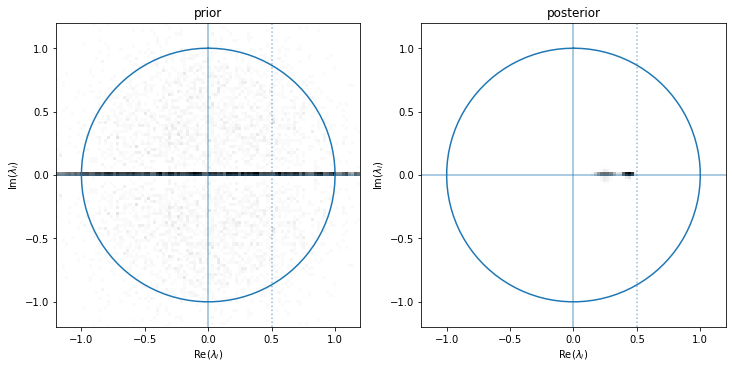

In [9]:
niter = 2000
bin_edges = np.linspace(-1.2, 1.2, 101)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
hist_gen_prior = np.zeros((bin_edges.size-1,bin_edges.size-1))
hist_gen_posterior = np.zeros((bin_edges.size-1,bin_edges.size-1))

sqrt_p = np.sqrt(p)
for i in range(niter):
    eig = np.linalg.eigvals(np.random.normal(size=(p,p), loc=phi_mu, scale=phi_sigma))
    hist_gen_prior += np.histogram2d(x=eig.real/sqrt_p, y=eig.imag/sqrt_p, bins=(bin_edges,bin_edges))[0]

for i in range(mcmc_gen['PHI'].shape[0]):
    eig = np.linalg.eigvals(mcmc_gen['PHI'][i,:,:])
    hist_gen_posterior += np.histogram2d(x=eig.real/sqrt_p, y=eig.imag/sqrt_p, bins=(bin_edges,bin_edges))[0]

fig, axs = plt.subplots(ncols=2, subplot_kw={'aspect':1.0}, figsize=(12,6))
axs[0].pcolormesh(bin_edges, bin_edges, hist_gen_prior.T, cmap=plt.get_cmap('gray_r'))
axs[1].pcolormesh(bin_edges, bin_edges, hist_gen_posterior.T, cmap=plt.get_cmap('gray_r'))
for ax in axs.flat:
    ax.plot(x_circ, y_circ)
    ax.axvline(0.0, color='C0', alpha=0.5)
    ax.axvline(1.0/np.sqrt(p), color='C0', alpha=0.5, ls=':')
    ax.axhline(0.0, color='C0', alpha=0.5)
    ax.set(xlabel='Re($\lambda_i$)', ylabel='Im($\lambda_i$)')
axs[0].set_title('prior')
axs[1].set_title('posterior')
None

### compare phylum and genus posterior

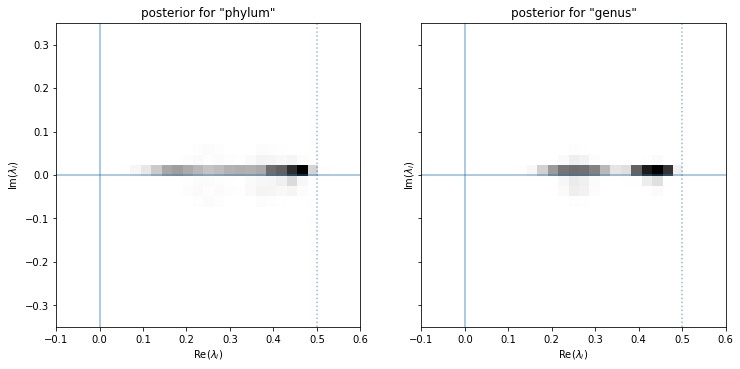

In [10]:
fig, axs = plt.subplots(ncols=2, subplot_kw={'aspect':1.0}, figsize=(12,6), sharex=True, sharey=True)
axs[0].pcolormesh(bin_edges, bin_edges, hist_posterior.T, cmap=plt.get_cmap('gray_r'))
axs[1].pcolormesh(bin_edges, bin_edges, hist_gen_posterior.T, cmap=plt.get_cmap('gray_r'))
for ax in axs.flat:
    ax.plot(x_circ, y_circ)
    ax.axvline(0.0, color='C0', alpha=0.5)
    ax.axvline(1.0/np.sqrt(p), color='C0', alpha=0.5, ls=':')
    ax.axhline(0.0, color='C0', alpha=0.5)
    ax.set(xlabel='Re($\lambda_i$)', ylabel='Im($\lambda_i$)')
axs[0].set_title('posterior for "phylum"')
axs[1].set_title('posterior for "genus"')

axs[0].set(xlim=(-0.1,1/np.sqrt(p)+0.1), ylim=(-0.5/np.sqrt(p)-0.1, 0.5/np.sqrt(p)+0.1))
None

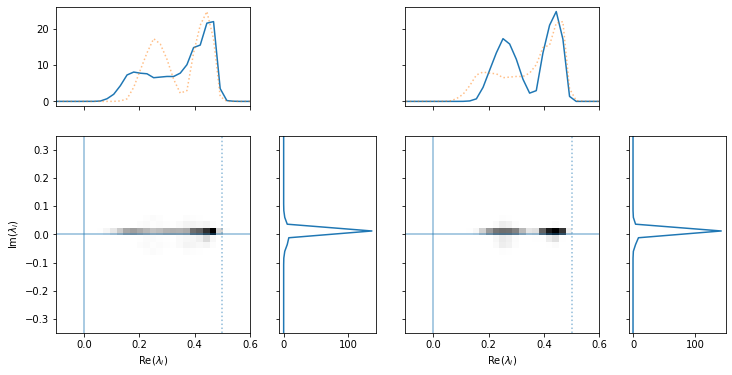

In [15]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12,6), sharex='col', sharey='row', gridspec_kw={'height_ratios':(1,2), 'width_ratios':(2,1,2,1)})
axs[1,0].pcolormesh(bin_edges, bin_edges, hist_posterior.T, cmap=plt.get_cmap('gray_r'))
axs[1,2].pcolormesh(bin_edges, bin_edges, hist_gen_posterior.T, cmap=plt.get_cmap('gray_r'))

axs[0,0].plot(bin_centers, np.mean(hist_posterior,axis=1))
axs[0,0].plot(bin_centers, np.mean(hist_gen_posterior,axis=1),alpha=0.5,ls=':')
axs[1,1].plot(np.mean(hist_posterior,axis=0),bin_centers)

axs[0,2].plot(bin_centers, np.mean(hist_gen_posterior,axis=1))
axs[0,2].plot(bin_centers, np.mean(hist_posterior,axis=1),alpha=0.5,ls=':')
axs[1,3].plot(np.mean(hist_gen_posterior,axis=0),bin_centers)

axs[1,0].set(xlabel='Re($\lambda_i$)', ylabel='Im($\lambda_i$)')
axs[1,2].set(xlabel='Re($\lambda_i$)')

for ax in axs[1,0::2]:
    ax.plot(x_circ, y_circ)
    ax.axvline(0.0, color='C0', alpha=0.5)
    ax.axvline(1.0/np.sqrt(p), color='C0', alpha=0.5, ls=':')
    ax.axhline(0.0, color='C0', alpha=0.5)
    ax.set(xlim=(-0.1,1/np.sqrt(p)+0.1), ylim=(-0.5/np.sqrt(p)-0.1, 0.5/np.sqrt(p)+0.1))
    
for ax in axs[0,1::2]:
    ax.set_visible(False)

### examine the leading eigenvalues (largest real part)

In [27]:
leadeig = {}

def get_leadeig(matrix):
    eig = np.linalg.eigvals(matrix)
    #eig.sort(key=lambda x: x.real)
    return np.sort_complex(eig)[-1]

leadeig['prior'] = np.full((niter,2), fill_value=np.nan)
for i in range(niter):
    eig = get_leadeig(np.random.normal(size=(p,p), loc=phi_mu, scale=phi_sigma))
    leadeig['prior'][i,0] = eig.real
    leadeig['prior'][i,1] = eig.imag

leadeig['phylum'] = np.full((mcmc['PHI'].shape[0],2), fill_value=np.nan)
for i in range(mcmc['PHI'].shape[0]):
    eig = get_leadeig(mcmc['PHI'][i,:,:])
    leadeig['phylum'][i,0] = eig.real
    leadeig['phylum'][i,1] = eig.imag
    
leadeig['genus'] = np.full((mcmc_gen['PHI'].shape[0],2), fill_value=np.nan)
for i in range(mcmc_gen['PHI'].shape[0]):
    eig = get_leadeig(mcmc_gen['PHI'][i,:,:])
    leadeig['genus'][i,0] = eig.real
    leadeig['genus'][i,1] = eig.imag

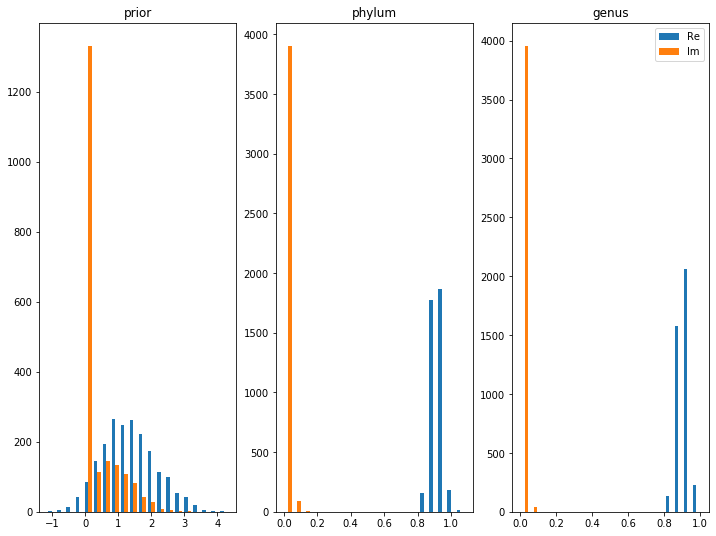

In [28]:
fig, axs = plt.subplots(ncols=len(leadeig), figsize=(12,9))
for ax,name in zip(axs,leadeig):
    ax.hist(leadeig[name], bins=20)
    ax.set_title(name)
ax.legend(('Re','Im'))

qq-plot

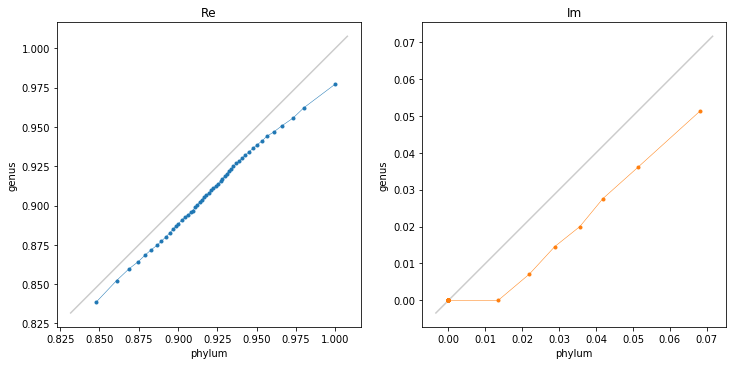

In [36]:
q_real = {k:np.percentile(leadeig[k][:,0], q=np.arange(1,100,2)) for k in ('phylum','genus')}
q_imag = {k:np.percentile(leadeig[k][:,1], q=np.arange(1,100,2)) for k in ('phylum','genus')}

fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].plot(q_real['phylum'], q_real['genus'], marker='.', lw=0.5)
axs[1].plot(q_imag['phylum'], q_imag['genus'], marker='.', lw=0.5, color='C1')
for ax,reim in zip(axs,('Re','Im')):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    lim = (min(xlim[0],ylim[0]), max(xlim[1],ylim[1]))
    ax.plot(lim,lim,color='0.8', zorder=0)
    ax.set(aspect=1.0, xlabel='phylum', ylabel='genus', title=reim)